# Converting the indications in DrugCentral to WikiData identifiers

In [1]:
import os
import requests
import pandas as pd
from pathlib import Path
from hetnet_ml.src import graph_tools as gt

### Drugcentral Data Dump previously extracted from postgres dump

See [here](https://github.com/mmayers12/semmed/tree/master/prepare) for more info.

In [2]:
sm_data_dir = Path('../../semmed/data/')

In [3]:
rel = pd.read_csv(sm_data_dir.joinpath('drugcentral_rel_06212018.csv'))
syn = pd.read_csv(sm_data_dir.joinpath('drugcentral_syn_06212018.csv'))
ids = pd.read_csv(sm_data_dir.joinpath('drugcentral_ids_06212018.csv'))

In [4]:
rel.head()

,id,struct_id,concept_id,relationship_name,concept_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0
2,173434,318,21003276,indication,Hyperuricemia,C0740394,Hyperuricemia,T047,35885006.0
3,173435,1031,21001432,indication,Hypertensive disorder,C0020538,Hypertensive disorder,T047,38341003.0
4,173397,5226,21001068,indication,Tardive dyskinesia,C0686347,Tardive dyskinesia,T047,102449007.0


In [5]:
syn.head()

,syn_id,id,name,preferred_name,parent_id,lname
0,22490,5253.0,RPX-7009,NaN,NaN,rpx-7009
1,22493,5003.0,insulin (human),NaN,NaN,insulin (human)
2,22494,5191.0,insulin (pork),NaN,NaN,insulin (pork)
3,22495,5192.0,insulin (beef),NaN,NaN,insulin (beef)
4,22496,1762.0,methyldopa (levorotatory),NaN,NaN,methyldopa (levorotatory)


In [6]:
ids.head()

,id,identifier,id_type,struct_id,parent_match
0,1214712,D11040,KEGG_DRUG,5278,NaN
1,1214713,9745,IUPHAR_LIGAND_ID,5271,NaN
2,1214714,9088,IUPHAR_LIGAND_ID,3911,NaN
3,1214715,CHEBI:43362,CHEBI,5229,NaN
4,1214716,CHEBI:63452,CHEBI,5231,NaN


In [7]:
ids['id_type'].unique()

array(['KEGG_DRUG', 'IUPHAR_LIGAND_ID', 'CHEBI', 'DRUGBANK_ID', 'VUID',
       'NUI', 'UMLSCUI', 'ChEMBL_ID', 'UNII', 'INN_ID',
       'SECONDARY_CAS_RN', 'PUBCHEM_CID', 'RXNORM', 'NDDF', 'MMSL',
       'VANDF', 'NDFRT', 'SNOMEDCT_US', 'MESH_SUPPLEMENTAL_RECORD_UI',
       'MESH_DESCRIPTOR_UI', 'PDB_CHEM_ID'], dtype=object)

In [8]:
ids['id_type'].value_counts()

ChEMBL_ID                      6148
SNOMEDCT_US                    4976
UNII                           4391
PUBCHEM_CID                    4308
NDFRT                          4260
CHEBI                          3830
MMSL                           3782
INN_ID                         3589
KEGG_DRUG                      3577
NDDF                           3383
RXNORM                         2991
DRUGBANK_ID                    2929
UMLSCUI                        2835
MESH_SUPPLEMENTAL_RECORD_UI    2589
VANDF                          2181
NUI                            2044
VUID                           1790
SECONDARY_CAS_RN               1669
MESH_DESCRIPTOR_UI             1591
IUPHAR_LIGAND_ID               1395
PDB_CHEM_ID                     727
Name: id_type, dtype: int64

## Disease Xrefs

### Query WikiData for Disease X-refs

In [9]:
import functools
from wikidataintegrator.wdi_core import WDItemEngine
from tqdm import tqdm

endpoint='https://query.wikidata.org/sparql'

def parse_result_uris(result):
    for c in result:
        if 'Label' not in c:
            idx = result[c].dropna().str.startswith('http://www.wikidata.org/entity')
            if idx.sum() != 0:
                idx = idx[idx].index
                result.loc[idx, c] = result.loc[idx, c].apply(lambda u: u.split('/')[-1])
    return result.drop_duplicates()

query_func = functools.partial(WDItemEngine.execute_sparql_query, endpoint=endpoint, as_dataframe=True)

def execute_sparql_query(query_text):
    # Enforce the proper column order
    
    
    col_order = query_text.split('\n')[1].split(' ?')[1:]
    return parse_result_uris(query_func(query_text))[col_order]

In [10]:
query = """
SELECT DISTINCT ?disease ?diseaseLabel ?umlscui ?snomed_ct
WHERE {

  # Initial typing for Disease
  ?disease wdt:P279?/wdt:P31 wd:Q12136 .

  OPTIONAL {?disease wdt:P2892 ?umlscui .}
  OPTIONAL {?disease wdt:P5806 ?snomed_ct. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }
}
"""

disease_xrefs = execute_sparql_query(query)
disease_xrefs.head(2)

,disease,diseaseLabel,umlscui,snomed_ct
0,Q8282,Addison's disease,C0405580,NaN
1,Q1485,systemic lupus erythematosus,C0024141,NaN


In [11]:
len(disease_xrefs)

23566

#### Remove those with no x-ref result

In [12]:
disease_xrefs = disease_xrefs.dropna(subset=['umlscui', 'snomed_ct'], how='all').reset_index(drop=True)
len(disease_xrefs)

16725

In [13]:
disease_xrefs.head(2)

,disease,diseaseLabel,umlscui,snomed_ct
0,Q8282,Addison's disease,C0405580,NaN
1,Q1485,systemic lupus erythematosus,C0024141,NaN


## Compound X-refs

### Start with DrugCentral's own x-refs

In [14]:
ids.head(2)

,id,identifier,id_type,struct_id,parent_match
0,1214712,D11040,KEGG_DRUG,5278,NaN
1,1214713,9745,IUPHAR_LIGAND_ID,5271,NaN


In [15]:
ids['id_type'].unique()

array(['KEGG_DRUG', 'IUPHAR_LIGAND_ID', 'CHEBI', 'DRUGBANK_ID', 'VUID',
       'NUI', 'UMLSCUI', 'ChEMBL_ID', 'UNII', 'INN_ID',
       'SECONDARY_CAS_RN', 'PUBCHEM_CID', 'RXNORM', 'NDDF', 'MMSL',
       'VANDF', 'NDFRT', 'SNOMEDCT_US', 'MESH_SUPPLEMENTAL_RECORD_UI',
       'MESH_DESCRIPTOR_UI', 'PDB_CHEM_ID'], dtype=object)

In [16]:
keep_ids = ['KEGG_DRUG', 'KEGG_DRUG', 'IUPHAR_LIGAND_ID', 'CHEBI', 'DRUGBANK_ID', 
        'UMLSCUI', 'ChEMBL_ID', 'UNII', 'INN_ID',
       'PUBCHEM_CID', 'RXNORM', 'NDFRT', 'MESH_SUPPLEMENTAL_RECORD_UI',
       'MESH_DESCRIPTOR_UI', 'PDB_CHEM_ID']

In [17]:
ids.head(2)

,id,identifier,id_type,struct_id,parent_match
0,1214712,D11040,KEGG_DRUG,5278,NaN
1,1214713,9745,IUPHAR_LIGAND_ID,5271,NaN


In [18]:
dc_xrefs = (ids.query('id_type in @keep_ids')
               .drop_duplicates(subset=['struct_id', 'id_type'])
               .pivot(values='identifier', index='struct_id', columns='id_type'))

In [19]:
dc_xrefs.head(2)

id_type,CHEBI,ChEMBL_ID,DRUGBANK_ID,INN_ID,IUPHAR_LIGAND_ID,KEGG_DRUG,MESH_DESCRIPTOR_UI,MESH_SUPPLEMENTAL_RECORD_UI,NDFRT,PDB_CHEM_ID,PUBCHEM_CID,RXNORM,UMLSCUI,UNII
struct_id,,,,,,,,,,,,,,
4,CHEBI:6149,CHEMBL1200749,DB01002,7465,7211,D01287,NaN,C476513,N0000148724,NaN,92253,259453,C0873118,A5H73K9U3W
5,CHEBI:135777,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6604415,NaN,NaN,NaN


### Now Query WikiData using the x-refs avalible to both soruces

In [20]:
id_to_wiki = {'KEGG_DRUG': 'P665', 
     'IUPHAR_LIGAND_ID': 'P595',
     'CHEBI': 'P683', 
     'DRUGBANK_ID': 'P715', 
     'UMLSCUI': 'P2892', 
     'ChEMBL_ID': 'P592', 
     'UNII': 'P652', 
     'INN_ID': 'P3350',
     'PUBCHEM_CID': 'P662', 
     'RXNORM': 'P3345', 
     'NDFRT': 'P2115', 
     'MESH_SUPPLEMENTAL_RECORD_UI': 'P6680',
     'MESH_DESCRIPTOR_UI': 'P486', 
     'PDB_CHEM_ID': 'P3636'}

In [21]:
base_query = """
SELECT DISTINCT ?compound ?compoundLabel {0}
WHERE {{

  # Initial typing for Compound
  ?compound wdt:P31 wd:Q11173 .

{1}

  SERVICE wikibase:label {{ bd:serviceParam wikibase:language "[AUTO_LANGAGE],en" }}
}}
"""

In [22]:
line_temp = "  OPTIONAL {{ ?compound wdt:{val} {key} .}}"
full_query = base_query.format(' '.join(['?'+k.lower() for k in id_to_wiki.keys()]), 
                               '\n'.join([line_temp.format(val=v, key='?'+k.lower()) for k, v in id_to_wiki.items()]))

In [23]:
print(full_query)


SELECT DISTINCT ?compound ?compoundLabel ?kegg_drug ?iuphar_ligand_id ?chebi ?drugbank_id ?umlscui ?chembl_id ?unii ?inn_id ?pubchem_cid ?rxnorm ?ndfrt ?mesh_supplemental_record_ui ?mesh_descriptor_ui ?pdb_chem_id
WHERE {

  # Initial typing for Compound
  ?compound wdt:P31 wd:Q11173 .

  OPTIONAL { ?compound wdt:P665 ?kegg_drug .}
  OPTIONAL { ?compound wdt:P595 ?iuphar_ligand_id .}
  OPTIONAL { ?compound wdt:P683 ?chebi .}
  OPTIONAL { ?compound wdt:P715 ?drugbank_id .}
  OPTIONAL { ?compound wdt:P2892 ?umlscui .}
  OPTIONAL { ?compound wdt:P592 ?chembl_id .}
  OPTIONAL { ?compound wdt:P652 ?unii .}
  OPTIONAL { ?compound wdt:P3350 ?inn_id .}
  OPTIONAL { ?compound wdt:P662 ?pubchem_cid .}
  OPTIONAL { ?compound wdt:P3345 ?rxnorm .}
  OPTIONAL { ?compound wdt:P2115 ?ndfrt .}
  OPTIONAL { ?compound wdt:P6680 ?mesh_supplemental_record_ui .}
  OPTIONAL { ?compound wdt:P486 ?mesh_descriptor_ui .}
  OPTIONAL { ?compound wdt:P3636 ?pdb_chem_id .}

  SERVICE wikibase:label { bd:servicePara

In [24]:
compound_xrefs = execute_sparql_query(full_query)
compound_xrefs.head(2)

,compound,compoundLabel,kegg_drug,iuphar_ligand_id,chebi,drugbank_id,umlscui,chembl_id,unii,inn_id,pubchem_cid,rxnorm,ndfrt,mesh_supplemental_record_ui,mesh_descriptor_ui,pdb_chem_id
0,Q43177,chlorophyll,C01793,NaN,28966,NaN,NaN,NaN,00WNZ48OR9,NaN,5748352,2388,N0000147223,NaN,D002734,NaN
1,Q139195,calcitriol,D00129,2779,46435,00136,C0006674,CHEMBL846,FXC9231JVH,NaN,5280453,1894,N0000146161,NaN,D002117,VDX


In [25]:
len(compound_xrefs)

167269

#### Remove those with no result

In [26]:
to_drop = [c for c in compound_xrefs][2:]

compound_xrefs = compound_xrefs.dropna(subset=to_drop, how='all')
len(compound_xrefs)

161019

In [27]:
compound_xrefs['compound'].nunique()

157585

In [28]:
chem_xref_order = [
    'unii', 
    'rxnorm', 
    'drugbank_id', 
    'umlscui', 
    'chebi', 
    'kegg_drug', 
    'iuphar_ligand_id', 
    'chembl_id', 
    'inn_id', 
    'pubchem_cid', 
    'ndfrt', 
    'pdb_chem_id',
    'mesh_supplemental_record_ui', 
    'mesh_descriptor_ui']

In [29]:
dc_xrefs = dc_xrefs.reset_index()
dc_xrefs.columns = dc_xrefs.columns.str.lower()

#### Build a Final set of x-refs for the compounds

In [30]:
final_chem_xrefs = []
remaining_chems = set(dc_xrefs['struct_id'])

for x in chem_xref_order:
    this_dc = dc_xrefs.query('struct_id in @remaining_chems').dropna(subset=[x])
    this_wd = compound_xrefs.dropna(subset=[x])
    
    this_xref = pd.merge(this_dc, this_wd, how='inner', on=x, suffixes=('_dc', '_wd'))
    final_chem_xrefs.append(this_xref)
    
    remaining_chems = remaining_chems - set(this_xref['struct_id'])

In [31]:
final_chem_xrefs = pd.concat(final_chem_xrefs, sort=False, ignore_index=True)
final_chem_xrefs.head(2)

,struct_id,chebi_dc,chembl_id_dc,drugbank_id_dc,inn_id_dc,iuphar_ligand_id_dc,kegg_drug_dc,mesh_descriptor_ui_dc,mesh_supplemental_record_ui_dc,ndfrt_dc,...,chebi,kegg_drug,iuphar_ligand_id,chembl_id,inn_id,pubchem_cid,ndfrt,pdb_chem_id,mesh_supplemental_record_ui,mesh_descriptor_ui
0,4,CHEBI:6149,CHEMBL1200749,DB01002,7465,7211,D01287,NaN,C476513,N0000148724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,CHEBI:6149,CHEMBL1200749,DB01002,7465,7211,D01287,NaN,C476513,N0000148724,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Build a map from DrugCentral internal Structure_id to WikiData identifier

In [32]:
struct_to_wd = final_chem_xrefs.groupby('struct_id')['compound'].apply(lambda s: ';'.join(set(s))).to_dict()

In [33]:
disease_xrefs.head(2)

,disease,diseaseLabel,umlscui,snomed_ct
0,Q8282,Addison's disease,C0405580,NaN
1,Q1485,systemic lupus erythematosus,C0024141,NaN


#### Build maps from UMLS and SNOMED to WikiData

Since Diseases have UMLS and Snomed IDs, we will build maps for both, and preferentially use the UMLS mappings

In [34]:
umls_to_wd = disease_xrefs.dropna(subset=['umlscui']).set_index('umlscui')['disease'].to_dict()
snomed_to_wd = disease_xrefs.dropna(subset=['snomed_ct']).set_index('snomed_ct')['disease'].to_dict()

In [35]:
rel.head(2)

,id,struct_id,concept_id,relationship_name,concept_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0


In [36]:
inds = rel.query('relationship_name == "indication"').copy()

In [37]:
inds['comp_wd_id'] = inds['struct_id'].map(struct_to_wd)

In [38]:
# Use UMLS first, then fill missing with SNOMED mappings
inds['dis_wd_id'] = inds['umls_cui'].map(umls_to_wd).fillna(inds['snomed_conceptid'].map(snomed_to_wd))

In [39]:
len(inds.dropna(subset=['comp_wd_id', 'dis_wd_id']))

4553

In [40]:
inds.head(2)

,id,struct_id,concept_id,relationship_name,concept_name,umls_cui,snomed_full_name,cui_semantic_type,snomed_conceptid,comp_wd_id,dis_wd_id
0,173432,965,40249340,indication,Malignant tumor of breast,C0006142,Malignant tumor of breast,T191,254837009.0,Q5308606,Q128581
1,173433,318,21000716,indication,Gout,C0018099,Gout,T047,90560007.0,Q410435,Q133087


## Compare Indications to Processed WikiData Dumps

In [41]:
wd_net_dir = Path('../2_pipeline/01_querying_wikidata_for_hetnet_edges/out/').resolve()

nodes_final = pd.read_csv(wd_net_dir.joinpath('2019-09-13/nodes.csv'))
nodes_2018 = pd.read_csv(wd_net_dir.joinpath('2018-11-12/nodes.csv'))
nodes_2018_02 = pd.read_csv(wd_net_dir.joinpath('2018-02-05/nodes.csv'))
nodes_2017 = pd.read_csv(wd_net_dir.joinpath('2017-01-16/nodes.csv'))

### How many indications have both the compound and disease in each WikiData Hetnet?

In [42]:
nids = nodes_final[':ID']
len(inds.query('comp_wd_id in @nids and dis_wd_id in @nids'))

2940

In [43]:
nids = nodes_2018[':ID']
len(inds.query('comp_wd_id in @nids and dis_wd_id in @nids'))

2844

In [44]:
nids = nodes_2018_02[':ID']
len(inds.query('comp_wd_id in @nids and dis_wd_id in @nids'))

2027

In [45]:
nids = nodes_2017[':ID']
len(inds.query('comp_wd_id in @nids and dis_wd_id in @nids'))

1837

### How do the actual indications overlap between WikiData and DrugCentral

In [46]:
%matplotlib inline
from metapaths.tools.plot import venn2_pretty
import matplotlib.pyplot as plt

In [47]:
edges_final = gt.remove_colons(pd.read_csv(wd_net_dir.joinpath('2019-09-13/edges.csv'), dtype='str'))
edges_2018 = gt.remove_colons(pd.read_csv(wd_net_dir.joinpath('2018-11-12/edges.csv'), dtype='str'))
edges_2018_02 = gt.remove_colons(pd.read_csv(wd_net_dir.joinpath('2018-02-05/edges.csv'), dtype='str'))
edges_2017 = gt.remove_colons(pd.read_csv(wd_net_dir.joinpath('2017-01-16/edges.csv'), dtype='str'))

In [48]:
gs_wd_inds = set(inds.dropna(subset=['comp_wd_id', 'dis_wd_id'])[['comp_wd_id', 'dis_wd_id']].apply(tuple, axis=1))
len(gs_wd_inds)

4520

In [49]:
edges_final.head(2)

,start_id,end_id,type,qualifier,inner1
0,Q418656,Q422244,SIGNIFICANT_DRUG_INTERACTION_CdiC,NaN,NaN
1,Q407592,Q409595,SIGNIFICANT_DRUG_INTERACTION_CdiC,NaN,NaN


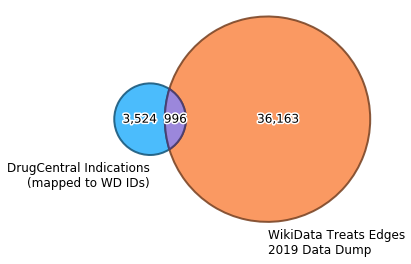

In [50]:
nw_year = '2019'
treats_edges = edges_final.query('type == "TREATS_CtD"')


treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))
venn2_pretty([gs_wd_inds, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])


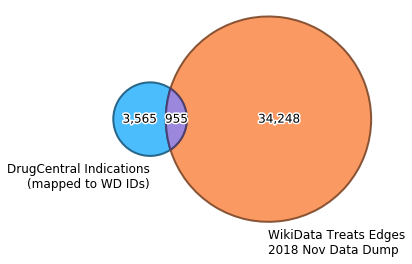

In [51]:
nw_year = '2018 Nov'
treats_edges = edges_2018.query('type == "TREATS_CtD"')


treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))
venn2_pretty([gs_wd_inds, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])


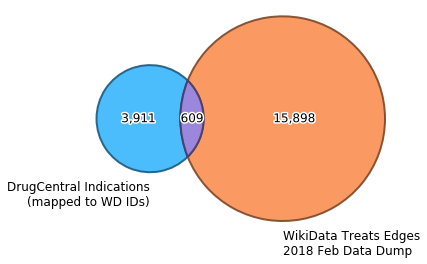

In [52]:
nw_year = '2018 Feb'
treats_edges = edges_2018_02.query('type == "TREATS_CtD"')


treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))
venn2_pretty([gs_wd_inds, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])


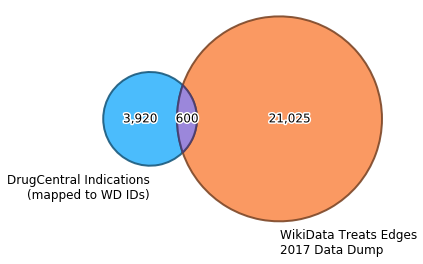

In [53]:
nw_year = '2017'
treats_edges = edges_2017.query('type == "TREATS_CtD"')


treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))
venn2_pretty([gs_wd_inds, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])


#### Looking only at Identifiers common to both DrugCentral Indications and WikiData Indications

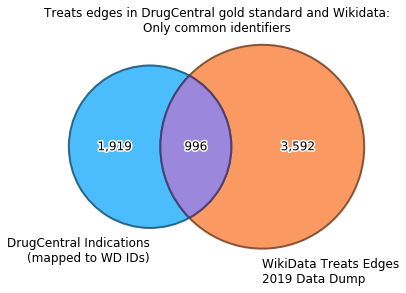

In [54]:
nw_year = '2019'
edges = edges_final

nids = edges[['start_id', 'end_id']].stack().unique()
gs_ids = inds[['comp_wd_id', 'dis_wd_id']].stack().dropna().unique()

treats_edges = edges.query('type == "TREATS_CtD" and start_id in @gs_ids and end_id in @gs_ids')
gs_edges = set(inds.query('comp_wd_id in @nids and dis_wd_id in @nids')[['comp_wd_id', 'dis_wd_id']].apply(tuple, axis=1))
treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))


venn2_pretty([gs_edges, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])
plt.title('Treats edges in DrugCentral gold standard and Wikidata:\nOnly common identifiers');

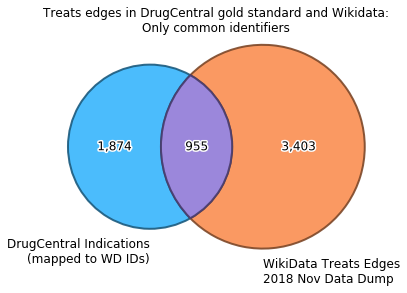

In [55]:
nw_year = '2018 Nov'
edges = edges_2018

nids = edges[['start_id', 'end_id']].stack().unique()
gs_ids = inds[['comp_wd_id', 'dis_wd_id']].stack().dropna().unique()

treats_edges = edges.query('type == "TREATS_CtD" and start_id in @gs_ids and end_id in @gs_ids')
gs_edges = set(inds.query('comp_wd_id in @nids and dis_wd_id in @nids')[['comp_wd_id', 'dis_wd_id']].apply(tuple, axis=1))
treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))

venn2_pretty([gs_edges, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])
plt.title('Treats edges in DrugCentral gold standard and Wikidata:\nOnly common identifiers');

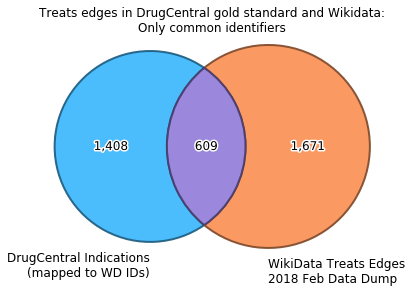

In [56]:
nw_year = '2018 Feb'
edges = edges_2018_02

nids = edges[['start_id', 'end_id']].stack().unique()
gs_ids = inds[['comp_wd_id', 'dis_wd_id']].stack().dropna().unique()

treats_edges = edges.query('type == "TREATS_CtD" and start_id in @gs_ids and end_id in @gs_ids')
gs_edges = set(inds.query('comp_wd_id in @nids and dis_wd_id in @nids')[['comp_wd_id', 'dis_wd_id']].apply(tuple, axis=1))
treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))

venn2_pretty([gs_edges, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])
plt.title('Treats edges in DrugCentral gold standard and Wikidata:\nOnly common identifiers');

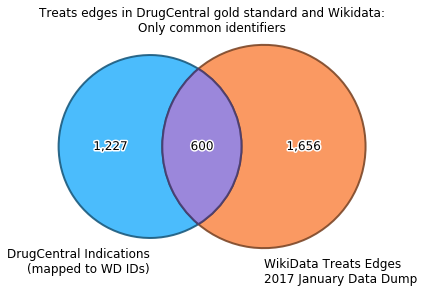

In [57]:
nw_year = '2017 January'
edges = edges_2017

nids = edges[['start_id', 'end_id']].stack().unique()
gs_ids = inds[['comp_wd_id', 'dis_wd_id']].stack().dropna().unique()

treats_edges = edges.query('type == "TREATS_CtD" and start_id in @gs_ids and end_id in @gs_ids')
gs_edges = set(inds.query('comp_wd_id in @nids and dis_wd_id in @nids')[['comp_wd_id', 'dis_wd_id']].apply(tuple, axis=1))
treats_edges = set(treats_edges[['start_id', 'end_id']].apply(tuple, axis=1))

venn2_pretty([gs_edges, treats_edges], ['DrugCentral Indications\n(mapped to WD IDs)', 
                                          'WikiData Treats Edges\n{} Data Dump'.format(nw_year)])
plt.title('Treats edges in DrugCentral gold standard and Wikidata:\nOnly common identifiers');

In [58]:
this_name = '05_converting_DrugCentral_indications_to_WikiData'

out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out')
out_dir.mkdir(parents=True, exist_ok=True)
    
inds.to_csv(out_dir.joinpath('gold_standard.csv'), index=False)